<a href="https://colab.research.google.com/github/pk2971/computational-gender-analysis/blob/main/notebooks/British_Parliament_Gender_EDA_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import re
import xml.etree.ElementTree as ET
from collections import defaultdict
import spacy
import matplotlib.pyplot as plt
import os
from concurrent.futures import ProcessPoolExecutor
import time
import multiprocessing
from collections import defaultdict

In [ ]:
zip_path = '/content/drive/MyDrive/debates.zip'


In [ ]:
# Gendered pronouns
male_pronouns = {"he", "him", "his"}
female_pronouns = {"she", "her", "hers"}

In [ ]:
VALID_YEARS = set(range(1919, 2025))

In [ ]:
# Clean and parse XML text
def extract_text_from_speech(xml_bytes):
    try:
        root = ET.fromstring(xml_bytes)
        return ' '.join([p.text or '' for p in root.findall('.//speech//p')])
    except ET.ParseError:
        return ""

In [ ]:
def process_xml_file(args):
    import spacy
    import zipfile

    filename, zip_path = args

    # Load spaCy model with sentence boundary detection
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "tagger", "lemmatizer"])
    nlp.add_pipe("sentencizer")

    try:
        year_str = filename[15:19]
        year = int(year_str)
        if year not in VALID_YEARS:
            return None
    except ValueError:
        return None

    with zipfile.ZipFile(zip_path, 'r') as z:
        with z.open(filename) as f:
            xml_bytes = f.read()

    text = extract_text_from_speech(xml_bytes)
    paragraphs = [p.strip() for p in text.split('\n') if p.strip()]
    if not paragraphs:
        return year, 0, 0

    male_count = 0
    female_count = 0

    for doc in nlp.pipe(paragraphs, batch_size=32):
        for token in doc:
            token_lower = token.text.lower()
            if token_lower in male_pronouns:
                male_count += 1
            elif token_lower in female_pronouns:
                female_count += 1

    return year, male_count, female_count


In [ ]:
def worker(args):
    return process_xml_file(args)

def main_parallel_processing(file_list, zip_path, batch_size=50):
    from collections import defaultdict
    import multiprocessing
    import time

    gender_counts = defaultdict(lambda: {'male': 0, 'female': 0})

    args_list = [(filename, zip_path) for filename in file_list]
    num_workers = multiprocessing.cpu_count()
    print(f"Starting multiprocessing with {num_workers} workers...")

    start_time = time.time()

    with multiprocessing.Pool(processes=num_workers) as pool:
        for i, result in enumerate(pool.imap_unordered(worker, args_list), 1):
            if result is not None:
                year, male_c, female_c = result
                gender_counts[year]['male'] += male_c
                gender_counts[year]['female'] += female_c

            if i % batch_size == 0 or i == len(args_list):
                elapsed = time.time() - start_time
                print(f"Processed {i}/{len(args_list)} files in {elapsed:.2f} seconds")

    total_time = time.time() - start_time
    print(f"Finished processing {len(args_list)} files in {total_time:.2f} seconds")

    return gender_counts


In [ ]:
with zipfile.ZipFile(zip_path, 'r') as z:
    xml_files = [
        f for f in z.namelist()
        if f.endswith('.xml') and '__MACOSX' not in f and not os.path.basename(f).startswith('._')
    ]

gender_counts = main_parallel_processing(xml_files, zip_path)
# print(gender_counts)


Starting multiprocessing with 44 workers...
Processed 50/19252 files in 5.73 seconds
Processed 100/19252 files in 9.91 seconds
Processed 150/19252 files in 13.94 seconds
Processed 200/19252 files in 17.67 seconds
Processed 250/19252 files in 21.52 seconds
Processed 300/19252 files in 25.39 seconds
Processed 350/19252 files in 29.76 seconds
Processed 400/19252 files in 33.74 seconds
Processed 450/19252 files in 37.54 seconds
Processed 500/19252 files in 40.48 seconds
Processed 550/19252 files in 44.13 seconds
Processed 600/19252 files in 47.96 seconds
Processed 650/19252 files in 51.51 seconds
Processed 700/19252 files in 55.31 seconds
Processed 750/19252 files in 59.40 seconds
Processed 800/19252 files in 62.65 seconds
Processed 850/19252 files in 66.27 seconds
Processed 900/19252 files in 69.70 seconds
Processed 950/19252 files in 73.56 seconds
Processed 1000/19252 files in 77.83 seconds
Processed 1050/19252 files in 81.00 seconds
Processed 1100/19252 files in 84.89 seconds
Processed 

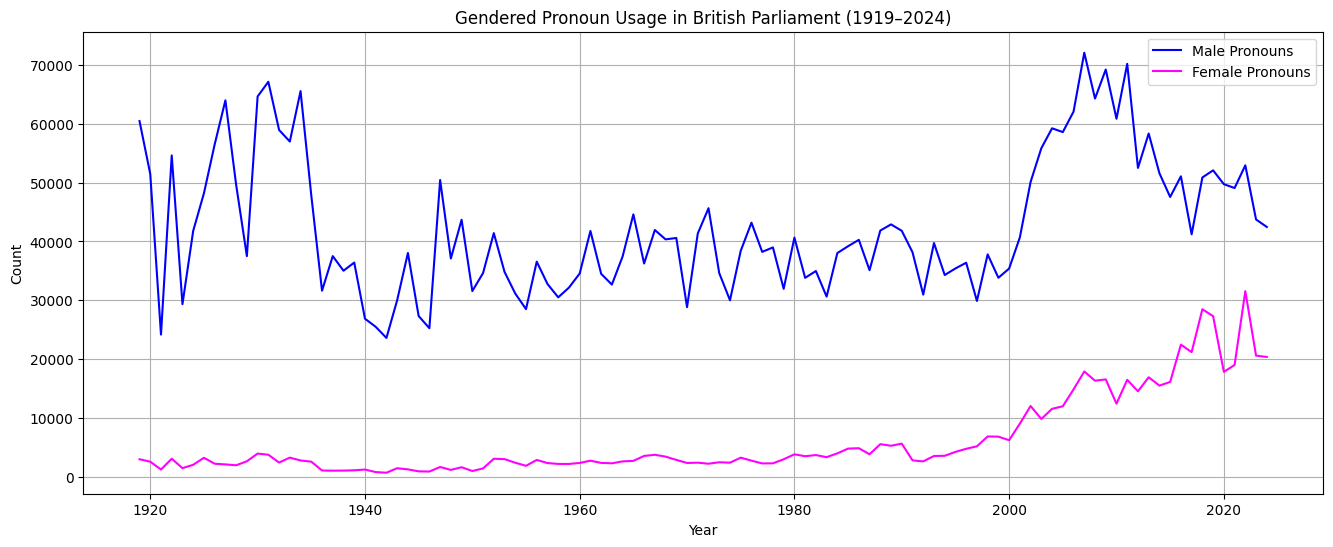

In [ ]:
years = sorted(gender_counts.keys())
male_counts = [gender_counts[year]['male'] for year in years]
female_counts = [gender_counts[year]['female'] for year in years]

# Plot
plt.figure(figsize=(16,6))
plt.plot(years, male_counts, label='Male Pronouns', color='blue')
plt.plot(years, female_counts, label='Female Pronouns', color='magenta')
plt.title('Gendered Pronoun Usage in British Parliament (1919–2024)')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()

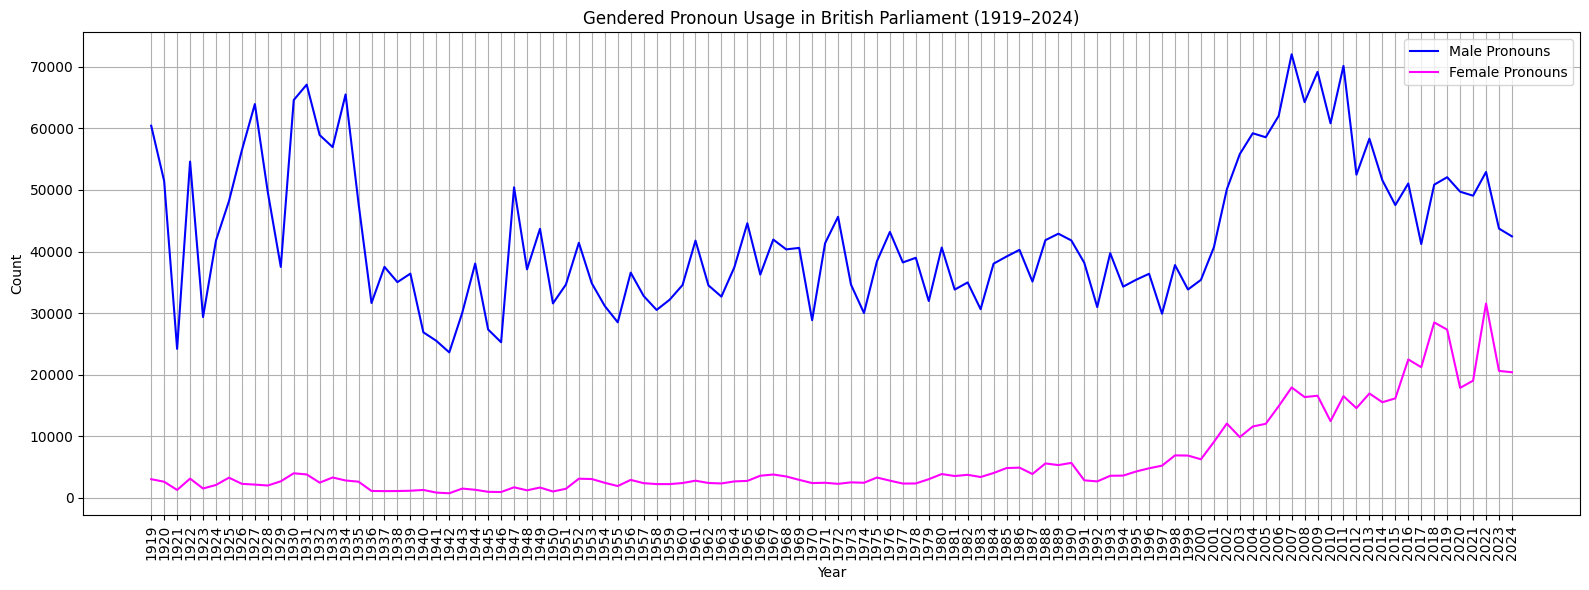

In [ ]:
# Every year
plt.figure(figsize=(16,6))
plt.plot(years, male_counts, label='Male Pronouns', color='blue')
plt.plot(years, female_counts, label='Female Pronouns', color='magenta')
plt.title('Gendered Pronoun Usage in British Parliament (1919–2024)')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(years, rotation=90)  # Show all years, rotate for readability
plt.legend()
plt.grid(True)
plt.tight_layout()  # Avoid clipping
plt.show()


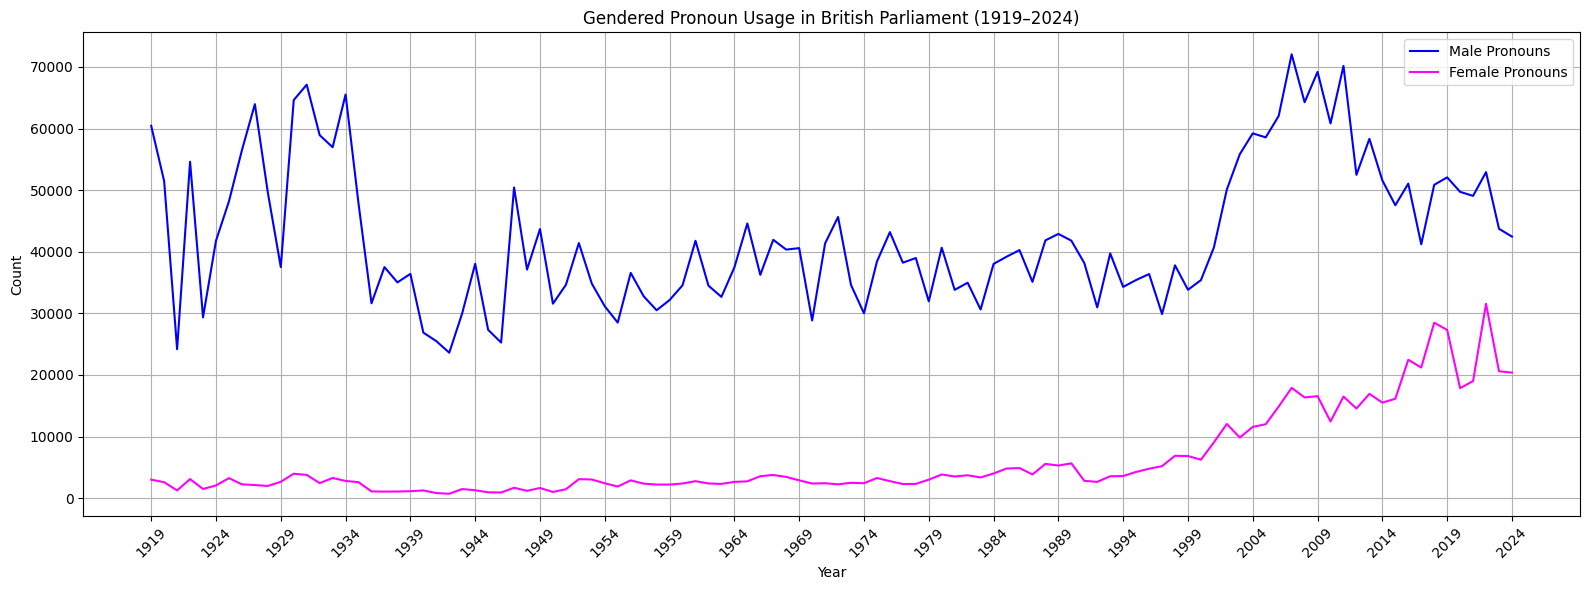

In [ ]:
# Every 5 years
import numpy as np

plt.figure(figsize=(16,6))
plt.plot(years, male_counts, label='Male Pronouns', color='blue')
plt.plot(years, female_counts, label='Female Pronouns', color='magenta')
plt.title('Gendered Pronoun Usage in British Parliament (1919–2024)')
plt.xlabel('Year')
plt.ylabel('Count')

# Show every 5th year only
every_nth = 5
tick_indices = np.arange(0, len(years), every_nth)
plt.xticks([years[i] for i in tick_indices], rotation=45)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import csv

with open('gender_pronoun_counts.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Year', 'Male Pronouns', 'Female Pronouns'])
    for year in sorted(gender_counts.keys()):
        writer.writerow([
            year,
            gender_counts[year]['male'],
            gender_counts[year]['female']
        ])
from google.colab import files
files.download('gender_pronoun_counts.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_pronoun_counts(csv_path, year_input, gender='both'):
    # Load CSV
    df = pd.read_csv(csv_path)

    # Ensure 'Year' is integer
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce').astype('Int64')
    df = df.dropna(subset=['Year'])
    df['Year'] = df['Year'].astype(int)

    # Filter by year or range
    if isinstance(year_input, int):
        df_filtered = df[df['Year'] == year_input]
    elif isinstance(year_input, (tuple, list)) and len(year_input) == 2:
        start_year, end_year = year_input
        df_filtered = df[(df['Year'] >= start_year) & (df['Year'] <= end_year)]
    else:
        raise ValueError("year_input must be an int or a (start_year, end_year) tuple")

    # Sort by year just in case
    df_filtered = df_filtered.sort_values(by='Year')

    # Plot
    plt.figure(figsize=(10, 5))

    if gender == 'male':
        plt.plot(df_filtered['Year'], df_filtered['Male Pronouns'], label='Male Pronouns', color='blue')
    elif gender == 'female':
        plt.plot(df_filtered['Year'], df_filtered['Female Pronouns'], label='Female Pronouns', color='red')
    elif gender == 'both':
        plt.plot(df_filtered['Year'], df_filtered['Male Pronouns'], label='Male Pronouns', color='blue')
        plt.plot(df_filtered['Year'], df_filtered['Female Pronouns'], label='Female Pronouns', color='red')
    else:
        raise ValueError("gender must be 'male', 'female', or 'both'")

    plt.xlabel('Year')
    plt.ylabel('Pronoun Count')
    plt.title(f"Pronoun Counts ({gender.capitalize()}) Over Time")
    plt.xticks(df_filtered['Year'].unique())  # Show only valid integer ticks
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


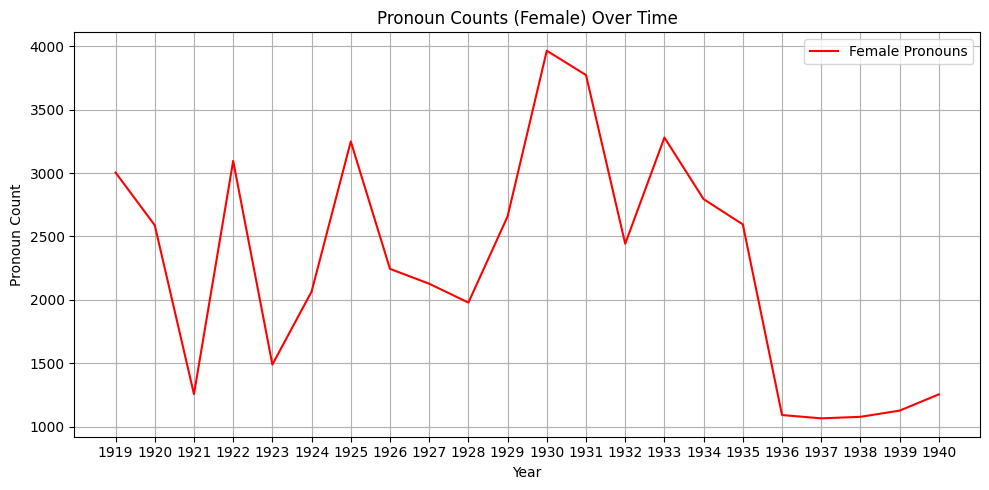

In [ ]:
csv="/content/gender_pronoun_counts.csv"
plot_pronoun_counts(csv, (1919,1940), gender='female')

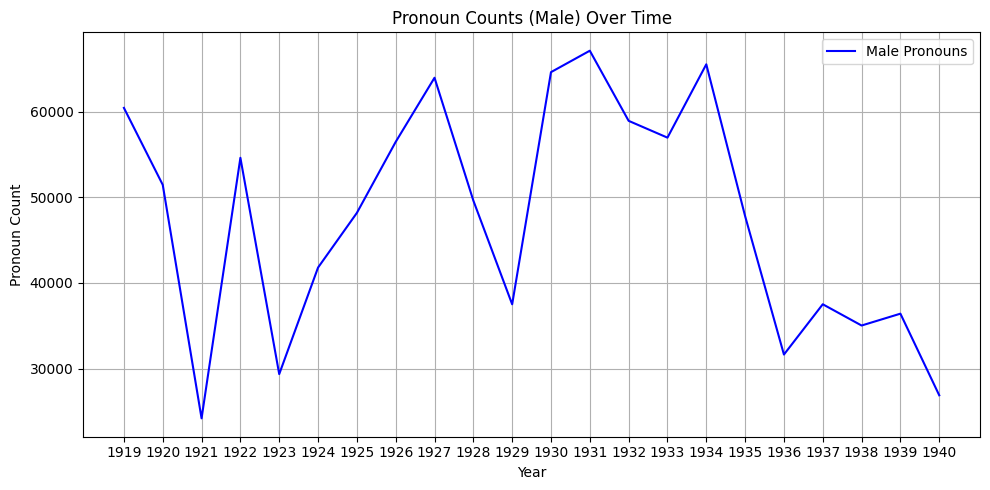

In [ ]:
plot_pronoun_counts(csv, (1919,1940), gender='male')